In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
aqi = pd.read_csv('data/avg_aqi_1988.csv')

In [4]:
X_gas = aqi[aqi['type']=='gas'][aqi['site']==35013].reset_index(drop=True)
X_gas = X_gas.rename(columns={'year':'Year', 'aqi':'AQI_Gas'})
X_gas = X_gas.drop(columns=['type','site'])
X_gas.dtypes

C:\Users\wuron\AppData\Local\Temp\ipykernel_11492\1576295369.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_gas = aqi[aqi['type']=='gas'][aqi['site']==35013].reset_index(drop=True)


Year         int64
AQI_Gas    float64
dtype: object

In [5]:
X_particle = aqi[aqi['type']=='particle'][aqi['site']==35013].reset_index(drop=True)
X_particle = X_particle.rename(columns={'year':'Year', 'aqi':'AQI_Particle'})
X_particle = X_particle.drop(columns=['type','site'])
X_particle.dtypes

C:\Users\wuron\AppData\Local\Temp\ipykernel_11492\2231808903.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_particle = aqi[aqi['type']=='particle'][aqi['site']==35013].reset_index(drop=True)


Year              int64
AQI_Particle    float64
dtype: object

### Since we are looking at the fire season, we are extracting only data from May to October

In [6]:
df_discharge_m = pd.read_csv('data/month_discharge.csv')
df_discharge_m = df_discharge_m[df_discharge_m['month_nu']>=5][df_discharge_m['month_nu']<=10]
df_discharge_m.shape

C:\Users\wuron\AppData\Local\Temp\ipykernel_11492\898964354.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_discharge_m = df_discharge_m[df_discharge_m['month_nu']>=5][df_discharge_m['month_nu']<=10]


(407, 8)

In [7]:
df_discharge_m = df_discharge_m.drop(columns=['agency_cd', 'site_no', 'ts_id', 'month_nu', 'parameter_cd'])
df_discharge_m = df_discharge_m.rename(columns={'year_nu':'Year', 'mean_va':'Mean_Water_Discharge', 'year_month':'Year_Month'})
X_discharge = df_discharge_m.groupby('Year')['Mean_Water_Discharge'].mean().reset_index()
X_discharge.dtypes


Year                      int64
Mean_Water_Discharge    float64
dtype: object

In [8]:
df_fire = pd.read_csv('data/wildfire_part2.csv')
X_fire = df_fire.drop(columns =['Listed_Fire_Dates','Listed_Fire_Start']).rename(columns={'Fire_Year':'Year'})
cnt = X_fire.groupby(by='Year').count()['GIS_Acres'].reset_index().rename(columns={'GIS_Acres':'Count'})
X_fire = X_fire.groupby(by='Year').mean()[['avg_distance (miles)', 'GIS_Acres']].reset_index()
# X_fire = X_fire[X_fire['Year']>=1988].reset_index(drop=True)

In [9]:
X_fire = X_fire.merge(cnt, on='Year')

In [10]:
a = X_fire['avg_distance (miles)']
b = np.sqrt(X_fire['GIS_Acres'])
c = X_fire['Count']
X_fire['Estimator'] = pd.Series(b*c**2/np.sqrt(a)/1e7)

In [11]:
X = X_fire.merge(X_discharge, on='Year').merge(X_particle, on='Year').merge(X_gas, on='Year')

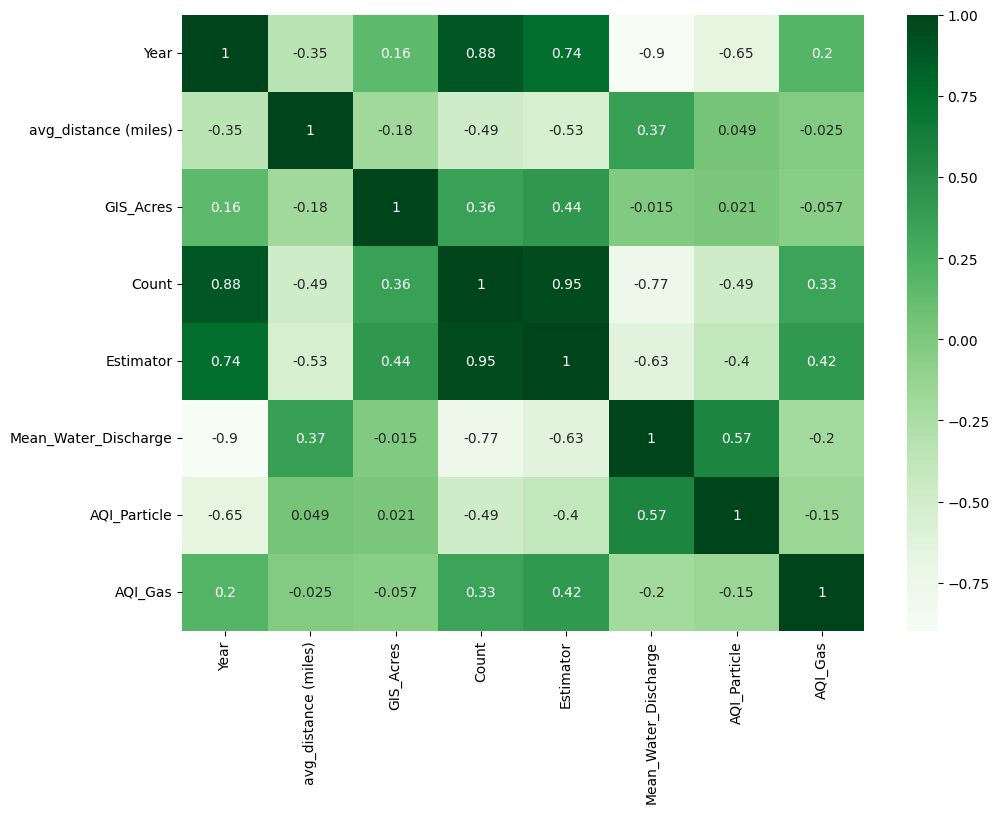

In [12]:
corr = X.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

In [13]:
df_n = pd.read_csv('data/nitrate_qtr.csv')[['Quarter', 'Nitrate-System Means (mcg/L)']]
df_h = pd.read_csv('data/haa_qtr.csv')[['Quarter', 'HAA-SystemsCount (mcg/L)']] # since 2007

compounds = [df_n, df_h]
qtr_to_day = {' Jan-Mar':'-Q1',' Apr-Jun':'-Q2',' Jul-Sep':'-Q3',' Oct-Dec':'-Q4'}

for compound in compounds:
    compound['Year'] = compound['Quarter'].str[:4].astype('int64')
    for k,v in zip(qtr_to_day.keys(), qtr_to_day.values()):
        compound['Quarter'] = compound['Quarter'].str.replace(k, v)
    compound['Quarter'] = compound['Quarter'].str[-2:]

In [14]:
idx_q1 = df_n[df_n['Quarter']=='Q1'].index
df_n = df_n.drop(idx_q1, axis=0).reset_index(drop=True)
idx_q2 = df_n[df_n['Quarter']=='Q2'].index
idx_q3 = df_n[df_n['Quarter']=='Q3'].index
idx_q4 = df_n[df_n['Quarter']=='Q4'].index
tmp = []
for i in range(df_n.shape[0]):
    if i in idx_q2:
        tmp.append(2/6)
    elif i in idx_q3:
        tmp.append(3/6)
    elif i in idx_q4:
        tmp.append(1/6)
df_n['Weighted Nitrate Means (mcg/L)'] = tmp * df_n['Nitrate-System Means (mcg/L)']
df_n = df_n.groupby(by='Year')['Weighted Nitrate Means (mcg/L)'].sum().reset_index()

In [15]:
idx_q1 = df_h[df_h['Quarter']=='Q1'].index
df_h = df_h.drop(idx_q1, axis=0).reset_index(drop=True)
idx_q2 = df_h[df_h['Quarter']=='Q2'].index
idx_q3 = df_h[df_h['Quarter']=='Q3'].index
idx_q4 = df_h[df_h['Quarter']=='Q4'].index
tmp = []
for i in range(df_h.shape[0]):
    if i in idx_q2:
        tmp.append(2/6)
    elif i in idx_q3:
        tmp.append(3/6)
    elif i in idx_q4:
        tmp.append(1/6)
df_h['Weighted HAA Count (mcg/L)'] = tmp * df_h['HAA-SystemsCount (mcg/L)']
df_h = df_h.groupby(by='Year')['Weighted HAA Count (mcg/L)'].sum().reset_index()

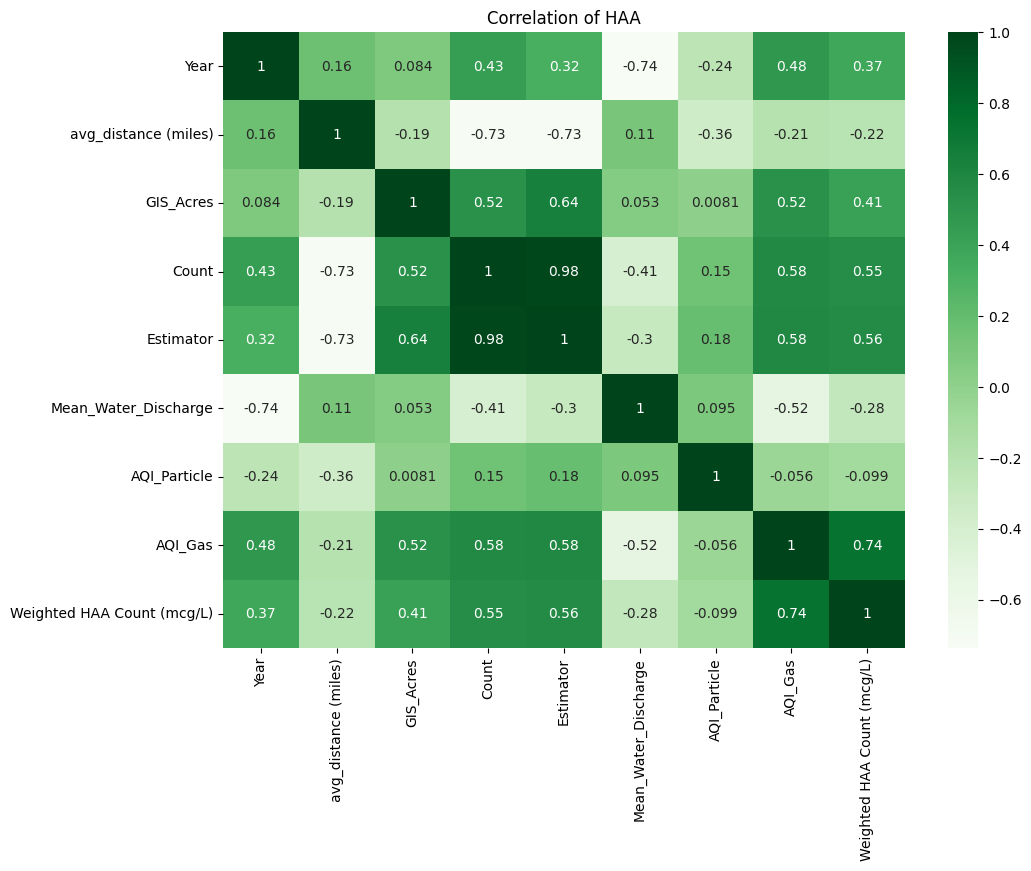

In [16]:
# check correlation on HAA5 with fire/water discharge

X_h = X.merge(df_h, on='Year')

corr_h = X_h.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr_h, cmap="Greens",annot=True)
plt.title('Correlation of HAA')
plt.show()

In [17]:
y_h = X_h['Weighted HAA Count (mcg/L)']
X_h_sub = np.array(X_h['Estimator']).reshape(-1,1)
# X_h_sub = X_h.drop(columns=['Year', 'Weighted HAA Count (mcg/L)', 'Mean_Water_Discharge'])

X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_h_sub, y_h, test_size=0.2, random_state=0)

reg_h = LinearRegression().fit(X_h_train, y_h_train)
print(reg_h.score(X_h_train, y_h_train))

0.4031288217682022


[2.43917958]
r2_score of HAAs: -7.165695918894107
MSE of HAAs: 10.569310356900884


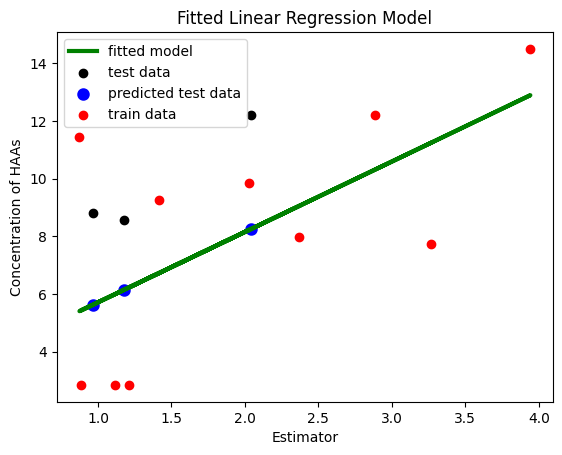

In [18]:
y_h_pred = reg_h.predict(X_h_test)
y_h_trainpred = reg_h.predict(X_h_train)
print(reg_h.coef_)
print('r2_score of HAAs:', r2_score(y_h_pred, y_h_test))
print('MSE of HAAs:', mean_squared_error(y_h_pred, y_h_test))

plt.scatter(X_h_test, y_h_test, color="black", label='test data')
plt.scatter(X_h_test, y_h_pred, color="blue", linewidth=3, label='predicted test data')
plt.scatter(X_h_train, y_h_train, color="red", label='train data')
plt.plot(X_h_train, y_h_trainpred, color="green", linewidth=3, label='fitted model')
plt.legend()
plt.xlabel('Estimator')
plt.ylabel('Concentration of HAAs')
# plt.xticks(())
# plt.yticks(())
plt.title('Fitted Linear Regression Model')
plt.show()

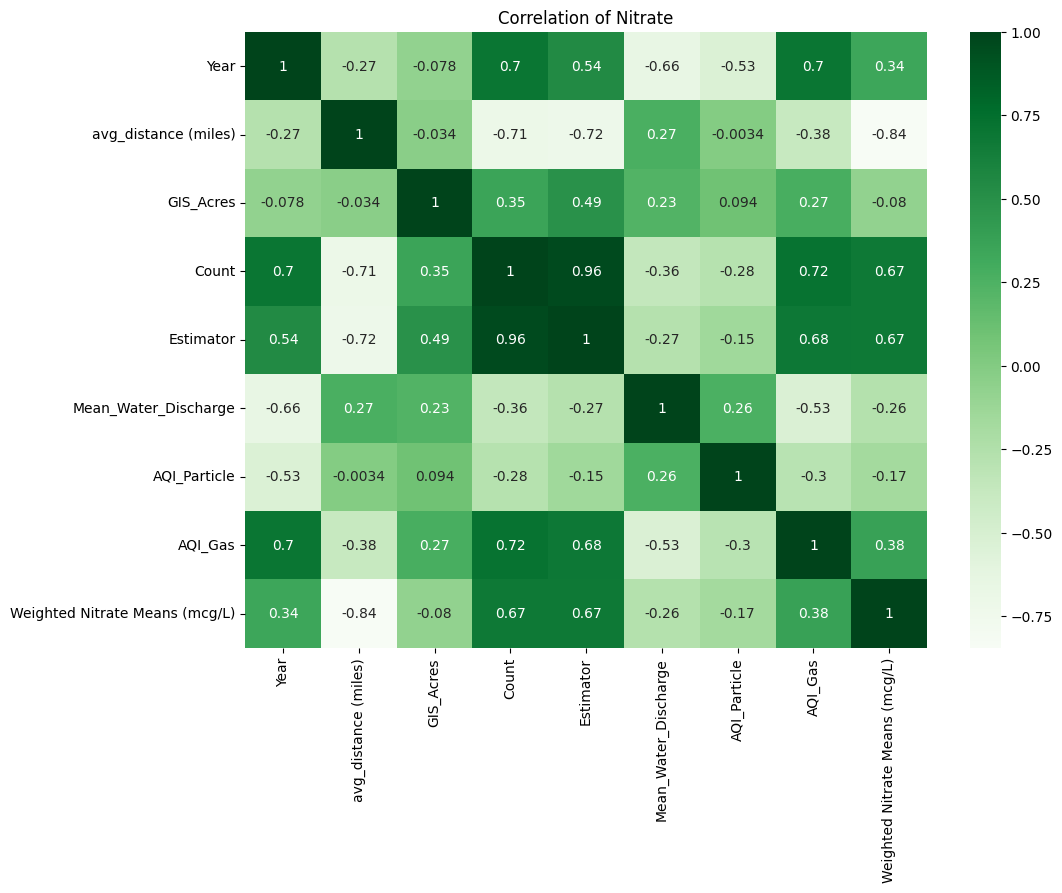

In [19]:
# check correlation on nitrate with fire/water discharge

X_n = X.merge(df_n, on='Year')

corr_n = X_n.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr_n, cmap="Greens",annot=True)
plt.title('Correlation of Nitrate')
plt.show()

In [20]:
y_n = X_n['Weighted Nitrate Means (mcg/L)']
X_n_sub = np.array(X_n['Estimator']).reshape(-1,1)

X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n_sub, y_n, test_size=0.2, random_state=1)

reg_n = LinearRegression().fit(X_n_train, y_n_train)
print(reg_n.score(X_n_train, y_n_train))

0.46197580037153485


[0.4244181]
r2_score of nitrate: 0.1613774091544945
MSE of nitrate: 0.09334335311957657


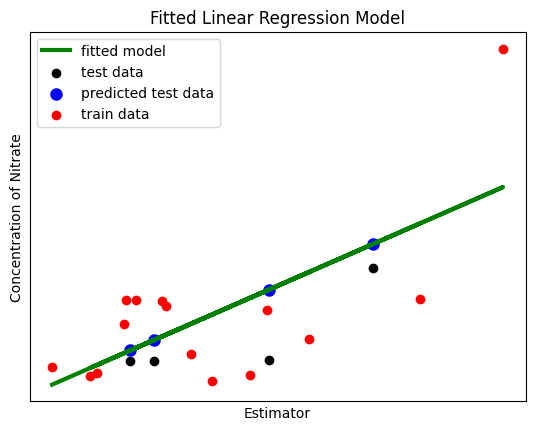

In [21]:
y_n_pred = reg_n.predict(X_n_test)
y_n_trainpred = reg_n.predict(X_n_train)
print(reg_n.coef_)
print('r2_score of nitrate:', r2_score(y_n_pred, y_n_test))
print('MSE of nitrate:', mean_squared_error(y_n_pred, y_n_test))

plt.scatter(X_n_test, y_n_test, color="black", label='test data')
plt.scatter(X_n_test, y_n_pred, color="blue", linewidth=3, label='predicted test data')
plt.scatter(X_n_train, y_n_train, color="red", label='train data')
plt.plot(X_n_train, y_n_trainpred, color="green", linewidth=3, label='fitted model')

plt.xlabel('Estimator')
plt.ylabel('Concentration of Nitrate')
plt.xticks(())
plt.yticks(())
plt.title('Fitted Linear Regression Model')
plt.legend()
plt.show()

In [22]:
temp_h = X_h[['Year', 'avg_distance (miles)', 'GIS_Acres', 'Count', 'AQI_Particle', 'AQI_Gas', 'Weighted HAA Count (mcg/L)']]
temp_h.corr()

,Year,avg_distance (miles),GIS_Acres,Count,AQI_Particle,AQI_Gas,Weighted HAA Count (mcg/L)
Year,1.000000,0.163897,0.083789,0.434887,-0.239049,0.480056,0.372843
avg_distance (miles),0.163897,1.000000,-0.191620,-0.725557,-0.355351,-0.205761,-0.219202
GIS_Acres,0.083789,-0.191620,1.000000,0.523088,0.008099,0.522981,0.412659
Count,0.434887,-0.725557,0.523088,1.000000,0.146381,0.576464,0.550811
AQI_Particle,-0.239049,-0.355351,0.008099,0.146381,1.000000,-0.056110,-0.098744
AQI_Gas,0.480056,-0.205761,0.522981,0.576464,-0.056110,1.000000,0.741473
Weighted HAA Count (mcg/L),0.372843,-0.219202,0.412659,0.550811,-0.098744,0.741473,1.000000


In [23]:
temp_n = X_n[['Year', 'avg_distance (miles)', 'GIS_Acres', 'Count', 'AQI_Particle', 'AQI_Gas', 'Weighted Nitrate Means (mcg/L)']]
temp_n.corr()

,Year,avg_distance (miles),GIS_Acres,Count,AQI_Particle,AQI_Gas,Weighted Nitrate Means (mcg/L)
Year,1.000000,-0.272297,-0.077891,0.701488,-0.531743,0.703251,0.338557
avg_distance (miles),-0.272297,1.000000,-0.033866,-0.705755,-0.003397,-0.376722,-0.844739
GIS_Acres,-0.077891,-0.033866,1.000000,0.353412,0.093677,0.273784,-0.079851
Count,0.701488,-0.705755,0.353412,1.000000,-0.279887,0.721753,0.669609
AQI_Particle,-0.531743,-0.003397,0.093677,-0.279887,1.000000,-0.295045,-0.167777
AQI_Gas,0.703251,-0.376722,0.273784,0.721753,-0.295045,1.000000,0.379603
Weighted Nitrate Means (mcg/L),0.338557,-0.844739,-0.079851,0.669609,-0.167777,0.379603,1.000000


In [24]:
X_sum = X_fire.merge(X_gas, on='Year').merge(X_particle, on='Year')
X_sum

,Year,avg_distance (miles),GIS_Acres,Count,Estimator,AQI_Gas,AQI_Particle
0,1988,874.046063,2644.958093,1540,0.412557,41.727026,45.065934
1,1989,809.169977,1065.345442,1342,0.206648,47.770985,41.400943
2,1990,916.973266,1157.738125,1111,0.138693,45.487738,34.231293
3,1991,921.542034,994.774146,972,0.098161,46.144928,30.590604
4,1992,906.282300,1313.456484,1092,0.143556,45.471582,31.230263
5,1993,769.490757,1444.667459,778,0.082936,40.892948,29.717608
6,1994,795.771653,2082.769560,1478,0.353407,43.057671,36.331269
7,1995,811.682524,1185.823137,1208,0.176381,41.313433,43.880952
8,1996,814.459041,3238.672284,1643,0.538300,40.173756,34.680928
9,1997,841.172628,834.691347,897,0.080150,39.209158,30.126545


Text(0.5, 0, 'Year')

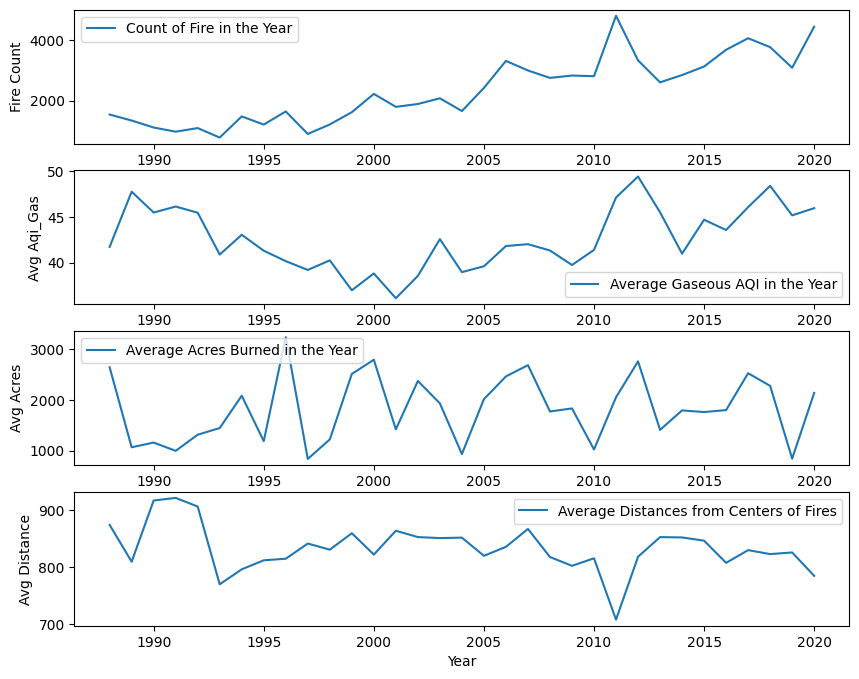

In [25]:
import numpy as np
from sklearn import preprocessing as pre
fig, ax = plt.subplots(4,1, figsize=(10,8))
ax[0].plot(X_sum['Year'], X_sum['Count'], label='Count of Fire in the Year')
ax[0].set_ylabel('Fire Count')
ax[0].legend()
ax[1].plot(X_sum['Year'], X_sum['AQI_Gas'], label='Average Gaseous AQI in the Year')
ax[1].set_ylabel('Avg Aqi_Gas')
ax[1].legend()
ax[2].plot(X_sum['Year'], X_sum['GIS_Acres'], label='Average Acres Burned in the Year')
ax[2].set_ylabel('Avg Acres')
ax[2].legend()
ax[3].plot(X_sum['Year'], X_sum['avg_distance (miles)'], label='Average Distances from Centers of Fires')
ax[3].set_ylabel('Avg Distance')
ax[3].legend()
plt.xlabel('Year')

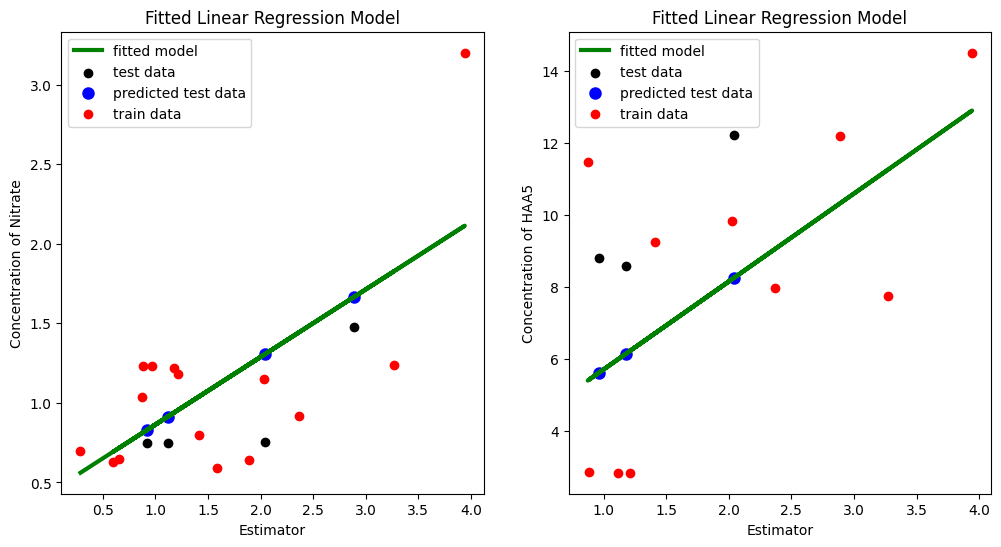

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,6))


ax[0].scatter(X_n_test, y_n_test, color="black", label='test data')
ax[0].scatter(X_n_test, y_n_pred, color="blue", linewidth=3, label='predicted test data')
ax[0].scatter(X_n_train, y_n_train, color="red", label='train data')
ax[0].plot(X_n_train, y_n_trainpred, color="green", linewidth=3, label='fitted model')
ax[0].legend()
ax[0].set_xlabel('Estimator')
ax[0].set_ylabel('Concentration of Nitrate')
ax[0].set_title('Fitted Linear Regression Model')

ax[1].scatter(X_h_test, y_h_test, color="black", label='test data')
ax[1].scatter(X_h_test, y_h_pred, color="blue", linewidth=3, label='predicted test data')
ax[1].scatter(X_h_train, y_h_train, color="red", label='train data')
ax[1].plot(X_h_train, y_h_trainpred, color="green", linewidth=3, label='fitted model')
ax[1].legend()
ax[1].set_xlabel('Estimator')
ax[1].set_ylabel('Concentration of HAA5')
ax[1].set_title('Fitted Linear Regression Model')

plt.savefig('Fitted_models')